# Portrait Segmentation on Celeb Faces Dataset

## This is a submission for the fellowship.ai auto portrait segmentation challenge
## The model is trained on the CelebAMask - HQ dataset with pre annotated labels

In [2]:
!nvidia-smi

Thu Jul 16 07:33:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Notebook Imports

In [3]:
import os
import cv2
import numpy as np
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from shutil import copyfile
import matplotlib.pyplot as plt

from keras import backend as K
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import save_img
from keras.utils import to_categorical, plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Conv2D, Conv2DTranspose, Activation, Input, concatenate, MaxPooling2D, BatchNormalization

% matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


# Constants

In [38]:
IMAGE_FOLDER = '/content/sample_data/CelebAMask-HQ/CelebA-HQ-img'
MASKS_FOLDER = '/content/sample_data/CelebAMask-HQ/CelebAMask-HQ-mask-anno/'
ANNO_FOLDER = '/content/sample_data/anno'

BATCH_SIZE = 50
HEIGHT = 128
WIDTH = 128
NO_CLASSES = 2
TRAIN_SIZE = 24000
VALIDATION_SIZE = 6000

# Mounting Google Drive to Load Data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [102]:
# !unzip "/content/drive/My Drive/CelebAMask-HQ.zip" -d "/content/sample_data"

In [103]:
# !unzip "/content/drive/My Drive/anno.zip" -d "/content/sample_data"

# Data Exploration

In [94]:
sample_image = cv2.imread(os.path.join(IMAGE_FOLDER, '733.jpg'))

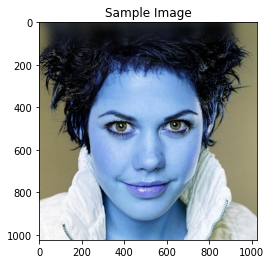

In [96]:
plt.imshow(sample_image)
plt.title('Sample Image')
plt.show()

In [10]:
sample_image.shape

(1024, 1024, 3)

In [11]:
sample_mask = cv2.imread(os.path.join(MASKS_FOLDER, '9/19602_l_eye.png'))

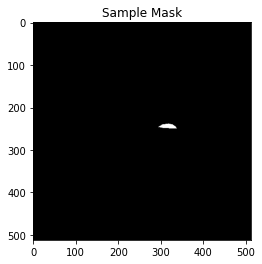

In [97]:
plt.imshow(sample_mask)
plt.title('Sample Mask')
plt.show()

## Data Preprocessing

### Annotations in dataset are for individual classes (eye, ear, nose, hat, etc.). They have to be combined to form complete mask.

In [13]:
# Get list of all annotations in masks folder

file_list = []
for root, dirnames, filenames in os.walk(MASKS_FOLDER):
  for file in filenames:
    file_list.append(os.path.join(root, file))

In [14]:
def generate_masks(anno_folder = ANNO_FOLDER, file_list = file_list):
  """
  Combines individual image annotations to image masks based on ID
  Arguments:
  anno_folder: path to folder to store generated masks
  file_list: list of file paths of individual annotations
  """
  
  id = '00000' # Initial ID
  mask = np.zeros((512, 512, 3), dtype='uint8') # Base for combining annotations
  for pic in tqdm(file_list):
    current_id = pic.split('/')[-1].split('_')[0] # Get ID from file name
    file_type = pic.split('/')[-1].split('.')[-1]
    if file_type == 'png': # Check for png files
      if current_id == id:
        mask_segment = imread(pic)
        mask = np.maximum(mask, mask_segment) # Add mask to base
      else:
        save_img(os.path.join(anno_folder, id+'_mask.png'), mask) # Save combined mask with image id in name
        id = current_id
        mask = np.zeros((512, 512, 3), dtype='uint8')
        mask_segment = imread(pic)
        mask = np.maximum(mask, mask_segment)
  save_img(os.path.join(anno_folder, id+'_mask.png'), mask)

In [15]:
# Masks were generated and zipped in a previous notebook. They were loaded in the data loading section

# generate_masks()
# !zip -r masks.zip /content/sample_data/anno

## Generating Dataset

### Utility Functions

In [16]:
def sort_function(str):
  """
  Function to pass to sorted function to sort based on numerical value of id
  """
  val = int(str.split('.')[0])
  return val

In [17]:
def load_image(path, filename, im_shape=(512, 512)):
  """
  Function to load and resize image
  Arguments:
  path: Path to image folder
  filename: Name of image file
  im_shape: Shape to scale the image to. Default (512, 512)
  """
  image = cv2.imread(os.path.join(path, filename)) / 255.0
  scaled_image = cv2.resize(image, im_shape, interpolation=cv2.INTER_AREA)
  return scaled_image

In [18]:
def load_binned_mask(path, filename, msk_shape=(512, 512)):
  """
  Function to load and conver mask to range 0-1
  Arguments:
  path: Path to mask folder
  filename: Name of mask file
  msk_shape: Shape to scale the mask to. Default (512, 512)
  """
  mask = cv2.imread(os.path.join(path, filename))
  scaled_mask = cv2.resize(mask, msk_shape, interpolation=cv2.INTER_AREA)
  bins = np.array([128])

  return np.digitize(scaled_mask, bins)

In [19]:
def data_generator(image_list, mask_list, batch_size):
  """
  Generator function for datasets
  Arguments:
  image_list: List of images
  mask_list: List of masks
  batch_size: Number of files per batch
  """
  while True:
    for i in range(0, len(image_list), batch_size):
      images_batch = image_list[i : i+batch_size]
      masks_batch = mask_list[i : i+batch_size]
      images = []
      masks = []
      for image, mask in zip(images_batch, masks_batch):
        images.append(load_image(IMAGE_FOLDER, image, (HEIGHT, WIDTH)))
        binned_mask = load_binned_mask(ANNO_FOLDER, mask, (HEIGHT, WIDTH))[:, :, 0]
        masks.append(np.expand_dims(binned_mask, axis=-1).astype('int16'))
      
      yield np.array(images), np.array(masks)

In [39]:
def train_validation_split(im_list, msk_list, train_size=TRAIN_SIZE):
  """
  Split and generate train and validation datasets
  """
  train_data_generator = data_generator(im_list[:train_size], msk_list[:train_size], BATCH_SIZE)
  validation_data_generator = data_generator(im_list[train_size:], msk_list[train_size:], BATCH_SIZE)

  return train_data_generator, validation_data_generator

### Train and Validation datasets

In [63]:
# List of all images in dataset

imlist = os.listdir(IMAGE_FOLDER)
images_list = sorted(imlist, key=sort_function)
print('Total number of images available:', len(images_list))

Total number of images available: 30000


In [64]:
# List of all corresponding masks

mask_list = os.listdir(ANNO_FOLDER)
mask_list.sort()
mask_list.remove('.ipynb_checkpoints') # Removing junk from masks generator function
mask_list.remove('.DS_mask.png')
print('Total number of masks available:', len(mask_list))

Total number of masks available: 30000


In [40]:
train_data_generator, validation_data_generator = train_validation_split(images_list, mask_list)

In [66]:
# Small dataset for testing
test_data_generator = data_generator(images_list[:-1000], mask_list[:-1000], BATCH_SIZE)

## View sample image and mask

In [41]:
sample_images, sample_masks = next(validation_data_generator)
image = sample_images[0]
mask = sample_masks[0]

print(sample_images.shape, sample_masks.shape)

(50, 128, 128, 3) (50, 128, 128, 1)


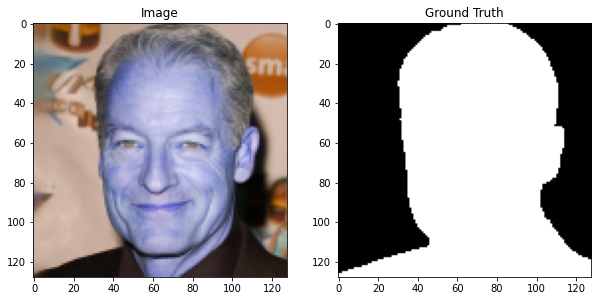

In [98]:
_, axes = plt.subplots(1, 2, figsize=(10, 15))
axes[0].imshow(image)
axes[0].set_title('Image')
axes[1].imshow(np.resize(mask, (HEIGHT, WIDTH)), cmap=plt.cm.binary_r)
axes[1].set_title('Ground Truth')
plt.show()

# Defining Evaluation Metrics

## Jaccard Index or IOU

In [26]:
def jaccard_index(y_true, y_pred, smooth=100):
  """
  Compute Jacard Distance between tensors

  Arguments:
  y_true: The ground truth tensor
  y_pred: The predicted tensor
  smooth: Smoothing factor. Default 100
  """
  intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
  sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
  jac = (intersection + smooth) / (sum_ - intersection + smooth)
  
  return jac

## Dice Coefficient

In [27]:
def dice_coef(y_true, y_pred, smooth=100):
  """
  Calculate Dice Coefficient

  Arguments:
  y_true: The ground truth tensor
  y_pred: The predicted tensor
  smooth: Smoothing factor. Default 100
  """
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

## Accuracy

In [28]:
def accuracy(y_true, y_pred, smooth=100):
  """
  Calculates the mean accuracy across all predictions

  Arguments:
  y_true: The ground truth tensor
  y_pred: The predicted tensor
  smooth: Smoothing factor. Default 100
  """

  return K.mean(K.equal(y_true, K.round(y_pred)))

# Model

In [29]:
def unet():
  input_img = Input((HEIGHT, WIDTH, 3), name='image')

  # Contracting Path

  c1 = Conv2D(8, (3, 3), padding='same')(input_img)
  c1 = BatchNormalization(momentum=0.0)(c1)
  c1 = Activation('relu')(c1)
  c1 = Conv2D(8, (3, 3), padding='same')(c1)
  c1 = BatchNormalization(momentum=0.0)(c1)
  c1 = Activation('relu')(c1)
  p1 = MaxPooling2D((2, 2))(c1)

  c2 = Conv2D(16, (3, 3), padding='same')(p1)
  c2 = BatchNormalization(momentum=0.0)(c2)
  c2 = Activation('relu')(c2)
  c2 = Conv2D(16, (3, 3), padding='same')(c2)
  c2 = BatchNormalization(momentum=0.0)(c2)
  c2 = Activation('relu')(c2)
  p2 = MaxPooling2D((2, 2))(c2)

  c3 = Conv2D(32, (3, 3),  padding='same')(p2)
  c3 = BatchNormalization(momentum=0.0)(c3)
  c3 = Activation('relu')(c3)
  c3 = Conv2D(32, (3, 3),  padding='same')(c3)
  c3 = BatchNormalization(momentum=0.0)(c3)
  c3 = Activation('relu')(c3)
  p3 = MaxPooling2D((2, 2))(c3)

  # Bottleneck

  c4 = Conv2D(64, (3, 3), padding='same')(p3)
  c4 = BatchNormalization(momentum=0.0)(c4)
  c4 = Activation('relu')(c4)
  c4 = Conv2D(64, (3, 2), padding='same')(c4)
  c4 = BatchNormalization(momentum=0.0)(c4)
  c4 = Activation('relu')(c4)

  # Expanding Path

  u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
  u5 = concatenate([u5, c3])
  c6 = Conv2D(32, (3, 3), padding='same')(u5)
  c6 = BatchNormalization(momentum=0.0)(c6)
  c6 = Activation('relu')(c6)
  c6 = Conv2D(32, (3, 3), padding='same')(c6)
  c6 = BatchNormalization(momentum=0.0)(c6)
  c6 = Activation('relu')(c6)

  u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
  u7 = concatenate([u7, c2])
  c8 = Conv2D(16, (3, 3), padding='same')(u7)
  c8 = BatchNormalization(momentum=0.0)(c8)
  c8 = Activation('relu')(c8)
  c8 = Conv2D(16, (3, 3), padding='same')(c8)
  c8 = BatchNormalization(momentum=0.0)(c8)
  c8 = Activation('relu')(c8)

  u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
  u9 = concatenate([u9, c1])
  c10 = Conv2D(8, (3, 3), padding='same')(u9)
  c10 = BatchNormalization(momentum=0.0)(c10)
  c10 = Activation('relu')(c10)
  c10 = Conv2D(8, (3, 3), padding='same')(c10)
  c10 = BatchNormalization(momentum=0.0)(c10)
  c10 = Activation('relu')(c10)

  outputs = Conv2D(1, (1, 1), activation='sigmoid')(c10)

  model = Model(inputs=[input_img], outputs=[outputs])
  return model

In [30]:
model = unet()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  224         image[0][0]                      
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 8)  32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 8)  0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

# Training

In [43]:
def train(model, learning_rate, checkpoint_file, train_data_generator, validation_data_generator, train_size, validation_size, epochs):
  """
  Train the model

  Arguments:
  model: Model to be trained
  learning_rate: Learning rate of the optimizer
  checkpoint_file: Path to save the model after each epoch
  train_data_generator: Generator for training data
  validatin_data_generator: Generator for validation data
  train_size: Number of training images
  validation_size: Number of validation images
  epochs: Number of epochs to train the model
  """
  adam = Adam(learning_rate=learning_rate)
  model.compile(optimizer=adam, loss='binary_crossentropy', metrics=[jaccard_index, dice_coef, accuracy])
  callbacks = [
               EarlyStopping(patience=5, verbose=1),
               ReduceLROnPlateau(patience=3, verbose=1),
               ModelCheckpoint(checkpoint_file, verbose=1, save_best_only=True)
  ]
  history = model.fit_generator(train_data_generator, epochs=epochs, steps_per_epoch=train_size//BATCH_SIZE,
                                validation_data=validation_data_generator, validation_steps=validation_size//BATCH_SIZE,
                                callbacks=callbacks)
  return history

## Train Model for 1 Epoch

In [ ]:
# history = train(model, 0.001, '/content/drive/My Drive/unet-1epoch-0.001lr.h5', train_data_generator, validation_data_generator,
#                 TRAIN_SIZE, VALIDATION_SIZE, 30)

## Train Model for 30 Epochs

In [45]:
history = train(model, 0.001, '/content/drive/My Drive/unet-30epoch-0.001lr.h5', train_data_generator, validation_data_generator,
                TRAIN_SIZE, VALIDATION_SIZE, 30)

Epoch 1/30
480/480 [==============================] - 644s 1s/step - loss: 0.1038 - jaccard_index: 0.9994 - dice_coef: 0.9574 - accuracy: 0.9589 - val_loss: 0.1005 - val_jaccard_index: 0.9994 - val_dice_coef: 0.9591 - val_accuracy: 0.9600

Epoch 00001: val_loss improved from inf to 0.10047, saving model to /content/drive/My Drive/unet-30epoch-0.001lr.h5
Epoch 2/30
480/480 [==============================] - 650s 1s/step - loss: 0.0983 - jaccard_index: 0.9994 - dice_coef: 0.9597 - accuracy: 0.9610 - val_loss: 0.1003 - val_jaccard_index: 0.9994 - val_dice_coef: 0.9604 - val_accuracy: 0.9608

Epoch 00002: val_loss improved from 0.10047 to 0.10034, saving model to /content/drive/My Drive/unet-30epoch-0.001lr.h5
Epoch 3/30
480/480 [==============================] - 655s 1s/step - loss: 0.0944 - jaccard_index: 0.9995 - dice_coef: 0.9613 - accuracy: 0.9626 - val_loss: 0.1022 - val_jaccard_index: 0.9995 - val_dice_coef: 0.9615 - val_accuracy: 0.9613

Epoch 00003: val_loss did not improve from 0

# Evaluation

## Metrics

In [99]:
model.load_weights('/content/drive/My Drive/unet-1epoch-0.001lr.h5')
print('----------------------------Metrics after 1 epochs----------------------------')
result = model.evaluate_generator(test_data_generator, 1000//BATCH_SIZE)
print(f'Loss : {result[0]:.2%}')
print(f'IOU : {result[1]:.2%}')
print(f'Dice Coefficient : {result[2]:.2%}')
print(f'Accuracy : {result[3]:.2%}')

----------------------------Metrics after 1 epochs----------------------------
Loss : 9.50%
IOU : 99.94%
Dice Coefficient : 95.84%
Accuracy : 95.79%


In [101]:
model.load_weights('/content/drive/My Drive/unet-30epoch-0.001lr.h5')
print('----------------------------Metrics after 30 epochs----------------------------')
result = model.evaluate_generator(test_data_generator, 1000//BATCH_SIZE)
print(f'Loss : {result[0]:.2%}')
print(f'IOU : {result[1]:.2%}')
print(f'Dice Coefficient : {result[2]:.2%}')
print(f'Accuracy : {result[3]:.2%}')

----------------------------Metrics after 30 epochs----------------------------
Loss : 8.00%
IOU : 99.95%
Dice Coefficient : 96.79%
Accuracy : 96.87%


## Training Statistics

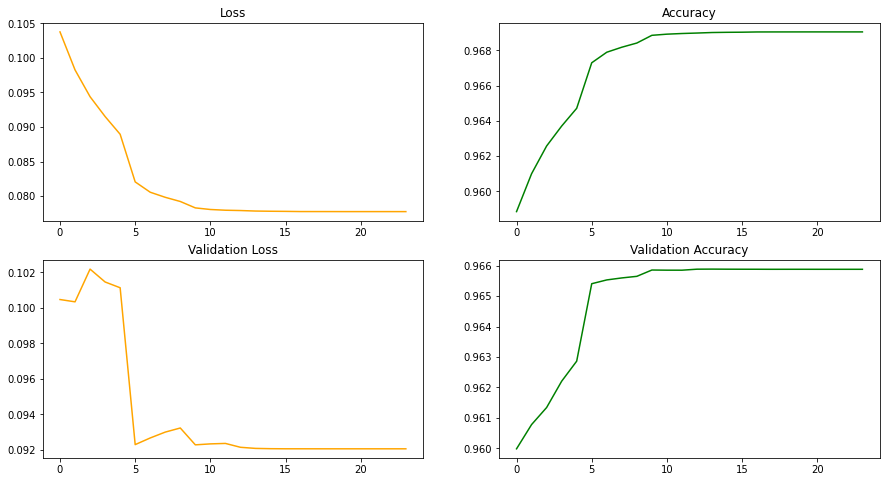

In [93]:
_, axes = plt.subplots(2, 2, figsize=(15, 8))
axes[0][0].plot(history.history['loss'], 'orange')
axes[0][0].set_title('Loss')
axes[0][1].plot(history.history['accuracy'], 'green')
axes[0][1].set_title('Accuracy')
axes[1][0].plot(history.history['val_loss'], 'orange')
axes[1][0].set_title('Validation Loss')
axes[1][1].plot(history.history['val_accuracy'], 'green')
axes[1][1].set_title('Validation Accuracy')
plt.show()

# Visualise Outputs

In [46]:
def enhance_mask(predicted_mask):
  """
  Sharpen output of Network
  Arguments:
  predicted_mask: Prediction of the network
  """
  e_mask = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1]), dtype='int8')
  for i in range(predicted_mask.shape[0]):
    for j in range(predicted_mask.shape[1]):
      if predicted_mask[i][j] < 0.5:
        e_mask[i][j] = 0
      else:
        e_mask[i][j] = 1
  return e_mask

In [47]:
test_images, test_masks = next(test_data_generator)

In [48]:
predicted_masks = model.predict(itest_images)

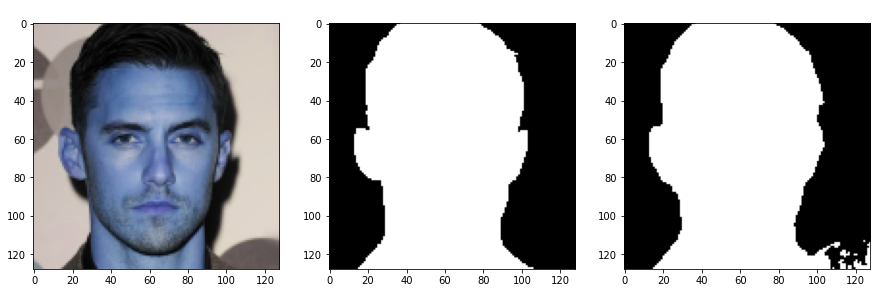

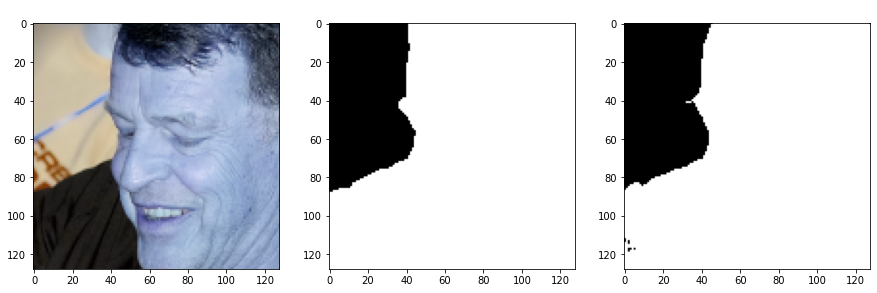

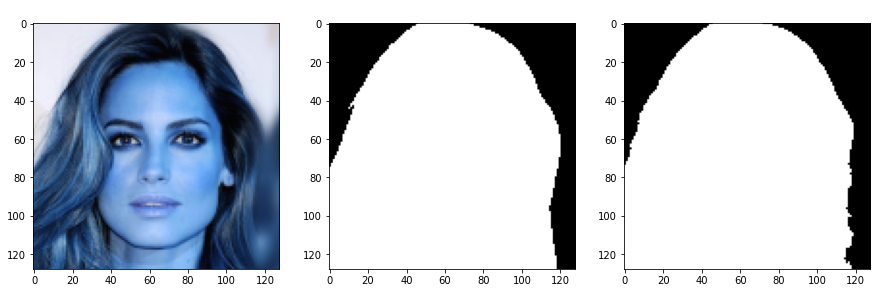

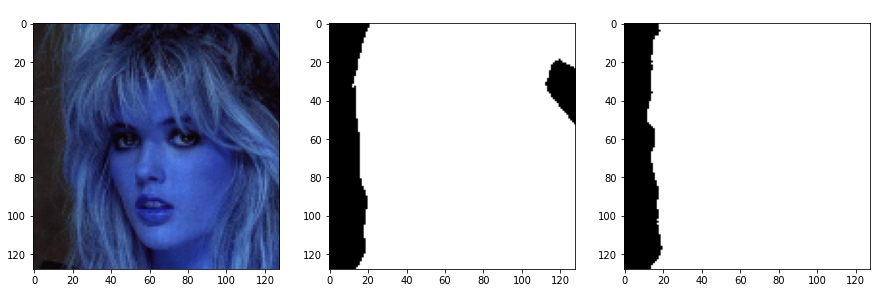

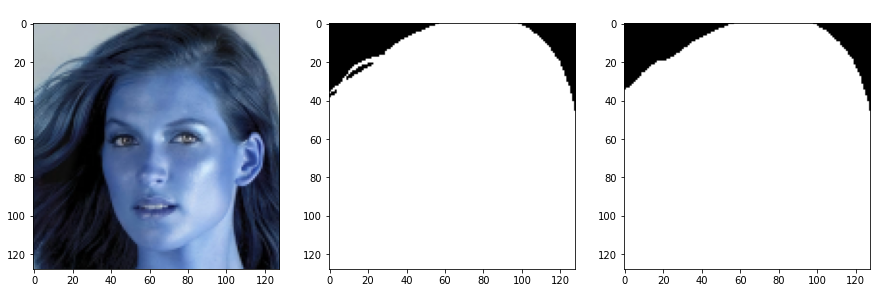

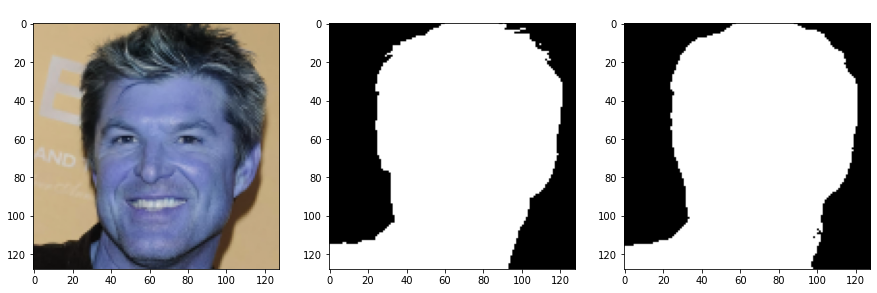

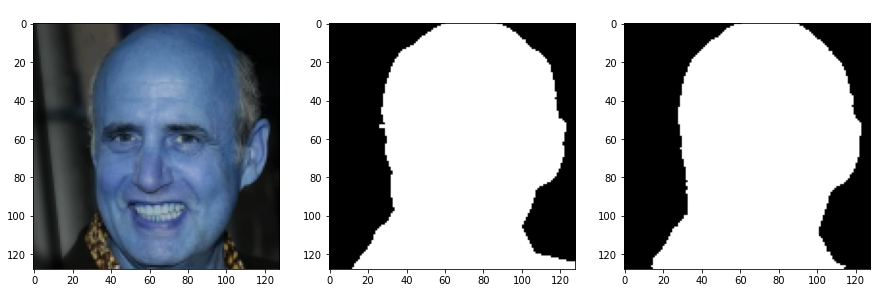

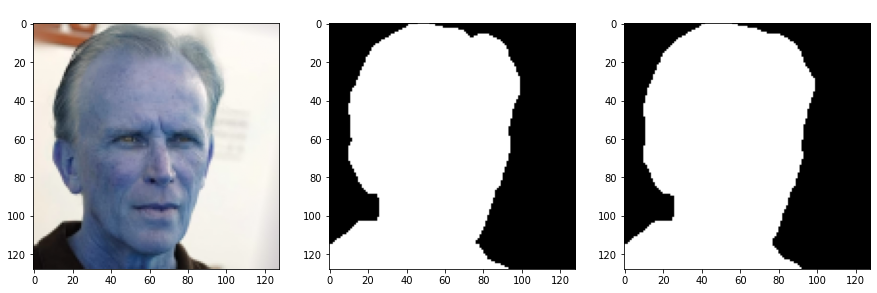

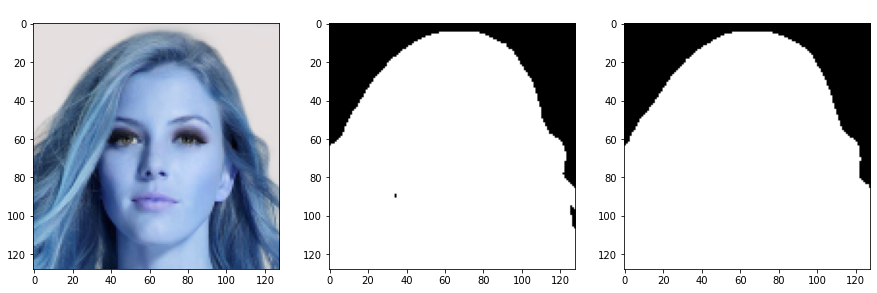

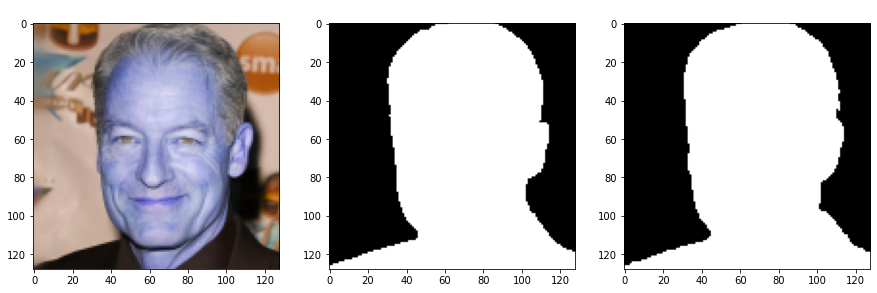

In [50]:
count = 0
for image, mask, predict in zip(i, m, predicted_masks):
  _, axes = plt.subplots(1, 3, figsize=(15, 8))
  axes[0].imshow(image)
  axes[0].set_title('Image', color='white')
  axes[1].imshow(mask.reshape(HEIGHT, WIDTH), cmap=plt.cm.binary_r)
  axes[1].set_title('Ground Truth', color='white')
  axes[2].imshow(enhance_mask(predict.reshape(HEIGHT, WIDTH)), cmap=plt.cm.binary_r)
  axes[2].set_title('Predicted Mask', color='white')
  count += 1
  if count == 10:
    break